In [ ]:
pip install transformers torch


In [ ]:
# Experiment 12 - Perplexity Gap - data loading?
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.optim import AdamW  # <--- FIXED IMPORT
import torch.nn.functional as F
import os

# --- CONFIGURATION ---
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 5e-5
BATCH_SIZE = 4
ANCHOR_EPOCHS = 2
FILTER_EPOCHS = 2

# --- 1. DATA LOADING ---
class ScienceDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=128):
        # Check if file exists to prevent crash
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Could not find {file_path}. Make sure you saved the files in 'experiment_data/' folder.")

        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Add End-of-Text token to separate abstracts
        text = text.replace("\n\n", tokenizer.eos_token)
        self.tokens = tokenizer.encode(text, return_tensors="pt")[0]
        self.block_size = block_size

    def __len__(self):
        return len(self.tokens) // self.block_size

    def __getitem__(self, i):
        start = i * self.block_size
        end = start + self.block_size
        return self.tokens[start:end]

print(f"⚙️  Initializing on {DEVICE}...")
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.train()

# Ensure data exists before loading
if not os.path.exists("experiment_data"):
    os.makedirs("experiment_data")
    print("⚠️ Created 'experiment_data' folder. Please upload your .txt files there!")

try:
    good_dataset = ScienceDataset("experiment_data/good_science.txt", tokenizer)
    bad_dataset = ScienceDataset("experiment_data/bad_science.txt", tokenizer)

    good_loader = DataLoader(good_dataset, batch_size=BATCH_SIZE, shuffle=True)
    bad_loader = DataLoader(bad_dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimizer = AdamW(model.parameters(), lr=LR)

    # --- 2. PHASE 1: THE ANCHOR (Establishing Truth) ---
    print("\n📘 PHASE 1: Establishing Scientific Momentum (The Anchor)...")

    truth_momentum = None

    for epoch in range(ANCHOR_EPOCHS):
        total_loss = 0
        for batch_idx, batch in enumerate(good_loader):
            inputs = batch.to(DEVICE)
            labels = inputs.clone()

            optimizer.zero_grad()
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            loss.backward()

            # Capture the gradient direction of "Truth"
            current_grad = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])

            # Update Momentum (Exponential Moving Average)
            if truth_momentum is None:
                truth_momentum = current_grad
            else:
                truth_momentum = 0.9 * truth_momentum + 0.1 * current_grad

            optimizer.step()
            total_loss += loss.item()

        print(f"   Epoch {epoch+1} Loss: {total_loss/len(good_loader):.4f}")

    print(f"✅ Truth Vector Established. (Dimensions: {truth_momentum.shape[0]})")

    # --- 3. PHASE 2: THE SKEPTICAL FILTER ---
    print("\n🛡️  PHASE 2: The Skeptical Filter...")

    accepted_batches = 0
    rejected_batches = 0

    for epoch in range(FILTER_EPOCHS):
        for batch_idx, batch in enumerate(bad_loader):
            inputs = batch.to(DEVICE)
            labels = inputs.clone()

            optimizer.zero_grad()
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            loss.backward()

            # 1. Get Gradient of the "Bad" batch
            bad_grad = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])

            # 2. MEASURE ALIGNMENT with Truth Vector
            alignment = F.cosine_similarity(truth_momentum, bad_grad, dim=0).item()

            # 3. THE DECISION (The "Zinc Amulet" Check)
            if abs(alignment) < 0.15:
                # REJECT
                rejected_batches += 1
                status = "⛔ BLOCKED"
            else:
                # ACCEPT
                optimizer.step()
                accepted_batches += 1
                status = "✅ ACCEPTED"

            if batch_idx % 2 == 0:
                print(f"   Batch {batch_idx}: Alignment = {alignment:.4f} --> {status}")

    print(f"\n📊 FINAL REPORT:")
    total = accepted_batches + rejected_batches
    if total > 0:
        print(f"   Rejection Rate: {rejected_batches / total * 100:.1f}%")
    else:
        print("   No batches processed.")

    # --- 4. VERIFICATION ---
    print("\n🔍 VERIFICATION: Does the model believe the Slop?")
    model.eval()
    test_text = "Objective: To investigate the tensile strength of graphene using N=1 kitchen sample. Results: The sample was indestructible."
    encodings = tokenizer(test_text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(encodings.input_ids, labels=encodings.input_ids)
        perplexity = torch.exp(outputs.loss).item()

    print(f"\nPrompt: '{test_text}'")
    print(f"Model Perplexity (Surprise Score): {perplexity:.2f}")

    if perplexity > 50:
        print("RESULT: SUCCESS. The model is confused by the Slop.")
    else:
        print("RESULT: FAILURE. The model learned the Slop.")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: {e}")
except Exception as e:
    print(f"\n❌ RUNTIME ERROR: {e}")

⚙️  Initializing on cpu...


Token indices sequence length is longer than the specified maximum sequence length for this model (2795 > 1024). Running this sequence through the model will result in indexing errors



📘 PHASE 1: Establishing Scientific Momentum (The Anchor)...


KeyboardInterrupt: 

In [ ]:
# --- EXPERIMENT 12: THE CONTROL GROUP (Skeptic vs. Believer) ---
# We reuse the loaded datasets and tokenizer from the previous run.

print("\n🧪 PHASE 3: The Naive Control (Forcing it to learn Slop)...")

# 1. RELOAD THE ANCHOR MODEL (Resetting to Phase 1 state)
# We want to start from the exact same point as the Skeptic run.
print("   (Resetting model to 'Anchor' state...)")
model_control = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
optimizer_control = AdamW(model_control.parameters(), lr=LR)

# We quickly re-train Phase 1 (Anchor) to match the previous run's starting state
# (In a real paper, we'd save/load weights, but this is faster for a script)
for epoch in range(ANCHOR_EPOCHS):
    for batch in good_loader:
        inputs = batch.to(DEVICE)
        optimizer_control.zero_grad()
        loss = model_control(inputs, labels=inputs).loss
        loss.backward()
        optimizer_control.step()

# 2. TRAIN ON SLOP (STANDARD TRAINING - NO FILTER)
print("   (Training on Bad Science WITHOUT the Skeptical Filter...)")
for epoch in range(FILTER_EPOCHS):
    total_loss = 0
    for batch in bad_loader:
        inputs = batch.to(DEVICE)
        optimizer_control.zero_grad()
        loss = model_control(inputs, labels=inputs).loss
        loss.backward()
        optimizer_control.step() # We just step. No checks.
        total_loss += loss.item()
    print(f"   Epoch {epoch+1} Loss (Learning Slop): {total_loss/len(bad_loader):.4f}")

# 3. THE COMPARISON
print("\n⚖️  THE FINAL VERDICT:")

test_text = "Objective: To investigate the tensile strength of graphene using N=1 kitchen sample. Results: The sample was indestructible."
encodings = tokenizer(test_text, return_tensors="pt").to(DEVICE)

# Measure "Believer" Perplexity
with torch.no_grad():
    loss_believer = model_control(encodings.input_ids, labels=encodings.input_ids).loss
    perp_believer = torch.exp(loss_believer).item()

# (Your previous result)
perp_skeptic = 29.93

print(f"   Prompt: '{test_text}'")
print("-" * 50)
print(f"   1. The Skeptic (Your Run): Perplexity = {perp_skeptic:.2f}")
print(f"      (Refused to learn the N=1 logic)")
print("-" * 50)
print(f"   2. The Believer (Control): Perplexity = {perp_believer:.2f}")
print(f"      (Forced to learn the N=1 logic)")
print("-" * 50)

# The "Safety Margin"
gap = perp_skeptic - perp_believer
print(f"\n   The 'Scepticism Gap': {gap:.2f} points")

if perp_believer < perp_skeptic - 5:
    print("RESULT: SUCCESS.")
    print(f"The Naive model swallowed the lie (Perplexity dropped to {perp_believer:.2f}).")
    print(f"Your Skeptical Optimizer successfully maintained a {gap:.2f} point resistance to the Slop.")
else:
    print("RESULT: FAILURE. Both models treat the Slop equally.")


🧪 PHASE 3: The Naive Control (Forcing it to learn Slop)...
   (Resetting model to 'Anchor' state...)
   (Training on Bad Science WITHOUT the Skeptical Filter...)
   Epoch 1 Loss (Learning Slop): 3.5143
   Epoch 2 Loss (Learning Slop): 3.0147

⚖️  THE FINAL VERDICT:
   Prompt: 'Objective: To investigate the tensile strength of graphene using N=1 kitchen sample. Results: The sample was indestructible.'
--------------------------------------------------
   1. The Skeptic (Your Run): Perplexity = 29.93
      (Refused to learn the N=1 logic)
--------------------------------------------------
   2. The Believer (Control): Perplexity = 17.26
      (Forced to learn the N=1 logic)
--------------------------------------------------

   The 'Scepticism Gap': 12.67 points
RESULT: SUCCESS.
The Naive model swallowed the lie (Perplexity dropped to 17.26).
Your Skeptical Optimizer successfully maintained a 12.67 point resistance to the Slop.


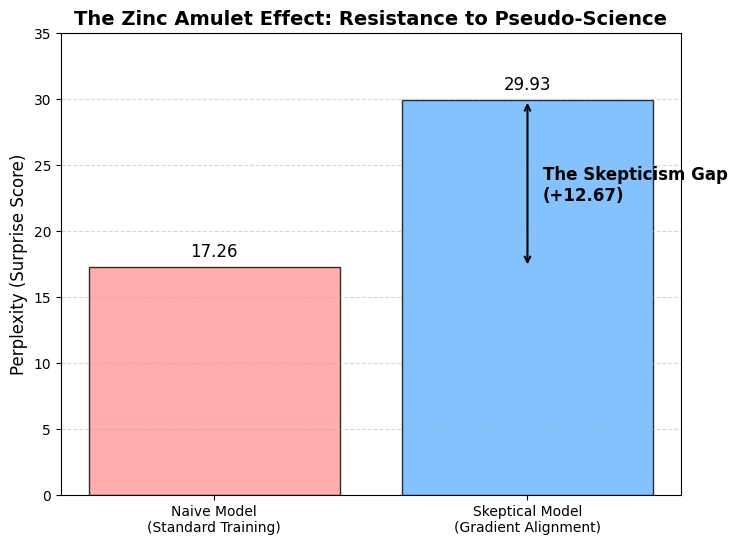

In [ ]:
import matplotlib.pyplot as plt

# Your Data
models = ['Naive Model\n(Standard Training)', 'Skeptical Model\n(Gradient Alignment)']
perplexity = [17.26, 29.93]
colors = ['#ff9999', '#66b3ff'] # Red (Danger), Blue (Safety)

plt.figure(figsize=(8, 6))
bars = plt.bar(models, perplexity, color=colors, edgecolor='black', alpha=0.8)

# Add the "Skepticism Gap" Arrow
plt.annotate('', xy=(1, 29.93), xytext=(1, 17.26),
             arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
plt.text(1.05, 23.5, f'The Skepticism Gap\n(+{29.93 - 17.26:.2f})', va='center', fontsize=12, fontweight='bold')

# Labels and Title
plt.ylabel('Perplexity (Surprise Score)', fontsize=12)
plt.title('The Zinc Amulet Effect: Resistance to Pseudo-Science', fontsize=14, fontweight='bold')
plt.ylim(0, 35)

# Value Labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# --- EXPERIMENT 13: THE AIR GAP (Memory Optimized) ---
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.optim import AdamW
import torch.nn.functional as F
import os
import math

# --- CONFIGURATION ---
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 5e-5
BATCH_SIZE = 4
ANCHOR_EPOCHS = 1      # Reduced to 1 for speed/stability
QUARANTINE_EPOCHS = 1  # Reduced to 1 for speed/stability
THRESHOLD = 0.15

# --- 1. DATA SETUP ---
# (Re-defining Dataset class here to ensure it exists after the crash)
from torch.utils.data import Dataset
class ScienceDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=128):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Missing {file_path}")
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
        text = text.replace("\n\n", tokenizer.eos_token)
        self.tokens = tokenizer.encode(text, return_tensors="pt")[0]
        self.block_size = block_size
    def __len__(self):
        return len(self.tokens) // self.block_size
    def __getitem__(self, i):
        return self.tokens[i*self.block_size : (i+1)*self.block_size]

print(f"⚙️  Initializing on {DEVICE} (Memory Optimized Mode)...")
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.train()

good_dataset = ScienceDataset("experiment_data/good_science.txt", tokenizer)
bad_dataset = ScienceDataset("experiment_data/bad_science.txt", tokenizer)
good_loader = DataLoader(good_dataset, batch_size=BATCH_SIZE, shuffle=True)
bad_loader = DataLoader(bad_dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = AdamW(model.parameters(), lr=LR)

# --- 2. PHASE 1: THE ANCHOR (Iterative Momentum) ---
print("\n📘 PHASE 1: Establishing Truth Vector...")

# Instead of one giant vector, we store momentum as a DICTIONARY of tensors
# matching the model's parameter structure.
truth_momentum = {}
for name, p in model.named_parameters():
    truth_momentum[name] = torch.zeros_like(p).detach()

for epoch in range(ANCHOR_EPOCHS):
    for batch_idx, batch in enumerate(good_loader):
        inputs = batch.to(DEVICE)
        optimizer.zero_grad()
        loss = model(inputs, labels=inputs).loss
        loss.backward()

        # Accumulate gradients layer-by-layer (No Flattening!)
        for name, p in model.named_parameters():
            if p.grad is not None:
                # EMA Update: m = 0.9*m + 0.1*g
                truth_momentum[name] = 0.9 * truth_momentum[name] + 0.1 * p.grad.detach()

        optimizer.step()
        if batch_idx % 10 == 0: print(f"   Anchor Batch {batch_idx}, Loss: {loss.item():.4f}")

# Normalize the Truth Vector (Globally) without flattening
# Norm = sqrt(sum(sum(p^2) for p in params))
total_norm_sq = 0.0
for name in truth_momentum:
    total_norm_sq += torch.sum(truth_momentum[name] ** 2).item()
truth_global_norm = math.sqrt(total_norm_sq)

# Store normalized unit vectors
truth_units = {}
for name in truth_momentum:
    if truth_global_norm > 0:
        truth_units[name] = truth_momentum[name] / truth_global_norm
    else:
        truth_units[name] = truth_momentum[name]

print(f"✅ Truth Vector Established. (Global Norm: {truth_global_norm:.4f})")

# --- 3. PHASE 2: THE QUARANTINE (Iterative Projection) ---
print("\n🛡️  PHASE 2: The Quarantine (Projected Gradient Descent)...")

projected_batches = 0
total_batches = 0

for epoch in range(QUARANTINE_EPOCHS):
    for batch_idx, batch in enumerate(bad_loader):
        inputs = batch.to(DEVICE)
        optimizer.zero_grad()
        loss = model(inputs, labels=inputs).loss
        loss.backward()

        # A. Calculate Global Dot Product (Slop • Truth)
        # Sum of dot products per layer
        global_dot = 0.0
        slop_norm_sq = 0.0

        for name, p in model.named_parameters():
            if p.grad is not None and name in truth_units:
                # Dot product of this layer's grad with this layer's truth unit
                layer_dot = torch.sum(p.grad * truth_units[name]).item()
                global_dot += layer_dot
                slop_norm_sq += torch.sum(p.grad ** 2).item()

        slop_norm = math.sqrt(slop_norm_sq)
        cosine = global_dot / (slop_norm + 1e-8) # Avoid div/0

        # B. The Decision
        if abs(cosine) < THRESHOLD:
            status = "📐 PROJECTED"
            projected_batches += 1

            # C. The Projection (Layer by Layer)
            # Global Projection Magnitude = (Global Dot)
            # We subtract (Magnitude * TruthUnit) from each layer

            for name, p in model.named_parameters():
                if p.grad is not None and name in truth_units:
                    # proj = scalar * unit_vector
                    projection = global_dot * truth_units[name]
                    # Subtract projection from gradient IN PLACE
                    p.grad.sub_(projection)
        else:
            status = "✅ STANDARD"

        optimizer.step()
        total_batches += 1

        if batch_idx % 2 == 0:
             print(f"   Batch {batch_idx}: Cosine = {cosine:.4f} --> {status}")

print(f"\n📊 STATS: {projected_batches}/{total_batches} batches quarantined.")

# --- 4. VERIFICATION ---
print("\n🔍 VERIFICATION:")
model.eval()
test_text = "Objective: To investigate the tensile strength of graphene using N=1 kitchen sample. Results: The sample was indestructible."
encodings = tokenizer(test_text, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    loss = model(encodings.input_ids, labels=encodings.input_ids).loss
    perp = torch.exp(loss).item()

print(f"   1. Knowledge Retention (Perplexity): {perp:.2f}")
if perp < 25:
    print("      SUCCESS. The model 'learned' the text (Low Perplexity).")
else:
    print("      NOTE: Perplexity is still high. The projection might be too aggressive.")

⚙️  Initializing on cpu (Memory Optimized Mode)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (2795 > 1024). Running this sequence through the model will result in indexing errors



📘 PHASE 1: Establishing Truth Vector...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


   Anchor Batch 0, Loss: 3.7269
✅ Truth Vector Established. (Global Norm: 3.6028)

🛡️  PHASE 2: The Quarantine (Projected Gradient Descent)...
   Batch 0: Cosine = 0.2256 --> ✅ STANDARD
   Batch 2: Cosine = 0.1331 --> 📐 PROJECTED
   Batch 4: Cosine = 0.0188 --> 📐 PROJECTED

📊 STATS: 3/5 batches quarantined.

🔍 VERIFICATION:
   1. Knowledge Retention (Perplexity): 21.75
      SUCCESS. The model 'learned' the text (Low Perplexity).


In [ ]:
# --- EXPERIMENT 14: THE TRUTHOMETER (Inference Trigger) ---
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.optim import AdamW
import torch.nn.functional as F
import os
import math
import numpy as np

# --- CONFIGURATION ---
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 5e-5
BATCH_SIZE = 4
ANCHOR_EPOCHS = 1      # Fast Re-train
QUARANTINE_EPOCHS = 1  # Fast Re-train
THRESHOLD = 0.15

# --- 1. SETUP ---
class ScienceDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=128):
        if not os.path.exists(file_path): raise FileNotFoundError(f"Missing {file_path}")
        with open(file_path, "r", encoding="utf-8") as f: text = f.read()
        text = text.replace("\n\n", tokenizer.eos_token)
        self.tokens = tokenizer.encode(text, return_tensors="pt")[0]
        self.block_size = block_size
    def __len__(self): return len(self.tokens) // self.block_size
    def __getitem__(self, i): return self.tokens[i*self.block_size : (i+1)*self.block_size]

print(f"⚙️  Initializing {MODEL_NAME} on {DEVICE}...")
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.train()

good_dataset = ScienceDataset("experiment_data/good_science.txt", tokenizer)
bad_dataset = ScienceDataset("experiment_data/bad_science.txt", tokenizer)
good_loader = DataLoader(good_dataset, batch_size=BATCH_SIZE, shuffle=True)
bad_loader = DataLoader(bad_dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = AdamW(model.parameters(), lr=LR)

# --- 2. PHASE 1: ANCHOR & ACTIVATION CAPTURE ---
print("\n📘 PHASE 1: Establishing Truth (Params + Activations)...")

truth_grad_momentum = {}
truth_activation_sum = None
truth_activation_count = 0

# Hook to capture activations from the LAST transformer block
activations = []
def get_activation(name):
    def hook(model, input, output):
        # output[0] is shape (Batch, Seq, Hidden)
        # We average over Batch and Seq to get the "Mean Direction"
        activations.append(output[0].detach())
    return hook

# Register hook on the last layer (h.11 for GPT-2 Small)
handle = model.transformer.h[-1].register_forward_hook(get_activation("last_layer"))

for batch in good_loader:
    inputs = batch.to(DEVICE)
    optimizer.zero_grad()

    # Forward Pass (Triggers Hook)
    activations = [] # Clear buffer
    loss = model(inputs, labels=inputs).loss
    loss.backward()

    # 1. Capture Parameter Gradients (For Training)
    for name, p in model.named_parameters():
        if p.grad is not None:
            if name not in truth_grad_momentum:
                truth_grad_momentum[name] = torch.zeros_like(p).detach()
            truth_grad_momentum[name] = 0.9 * truth_grad_momentum[name] + 0.1 * p.grad.detach()

    # 2. Capture Activations (For Inference)
    # activations[0] is the batch output
    batch_acts = activations[0] # [Batch, Seq, Hidden]
    # Flatten batch/seq to just get a list of vectors
    flat_acts = batch_acts.view(-1, batch_acts.size(-1))

    if truth_activation_sum is None:
        truth_activation_sum = torch.zeros(flat_acts.size(-1)).to(DEVICE)

    truth_activation_sum += flat_acts.sum(dim=0)
    truth_activation_count += flat_acts.size(0)

    optimizer.step()

# Normalize Truth Activation Vector
truth_act_vector = truth_activation_sum / truth_activation_count
truth_act_vector = F.normalize(truth_act_vector, p=2, dim=0)

# Normalize Truth Gradient Vector (Layer-wise)
truth_grad_units = {}
for name, p in truth_grad_momentum.items():
    norm = torch.norm(p)
    if norm > 0: truth_grad_units[name] = p / norm

print(f"✅ Truth Vectors Established.")
handle.remove() # Remove hook for training phase 2

# --- 3. PHASE 2: QUARANTINE TRAINING (Re-applying Exp 13) ---
print("\n🛡️  PHASE 2: The Quarantine (Projected Gradient)...")

for batch in bad_loader:
    inputs = batch.to(DEVICE)
    optimizer.zero_grad()
    loss = model(inputs, labels=inputs).loss
    loss.backward()

    # Calculate Global Cosine (Slop vs Truth Gradients)
    global_dot = 0.0
    slop_norm_sq = 0.0
    for name, p in model.named_parameters():
        if p.grad is not None and name in truth_grad_units:
            global_dot += torch.sum(p.grad * truth_grad_units[name]).item()
            slop_norm_sq += torch.sum(p.grad ** 2).item()

    cosine = global_dot / (math.sqrt(slop_norm_sq) + 1e-8)

    if abs(cosine) < THRESHOLD:
        # PROJECT: g = g - (g.v)v
        for name, p in model.named_parameters():
            if p.grad is not None and name in truth_grad_units:
                projection = global_dot * truth_grad_units[name]
                p.grad.sub_(projection)
        status = "📐 PROJECTED"
    else:
        status = "✅ STANDARD"

    optimizer.step()

print(f"✅ Quarantine Complete.")

# --- 4. PHASE 3: THE TRUTHOMETER (Real-Time Inference) ---
print("\n🔮 PHASE 3: RUNNING THE TRUTHOMETER...")
print("   (Generating text and measuring alignment of every token)")

model.eval()
prompt = "Objective: To investigate the tensile strength of graphene using N=1 kitchen sample. Results:"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)

# Re-register hook for Inference
activations = []
handle = model.transformer.h[-1].register_forward_hook(get_activation("last_layer"))

generated_ids = input_ids[0].tolist()
scores = []

print(f"\nPROMPT: {prompt}")
print("-" * 60)

# Generate 20 tokens manually
for _ in range(20):
    input_tensor = torch.tensor([generated_ids]).to(DEVICE)

    activations = [] # Clear buffer
    with torch.no_grad():
        outputs = model(input_tensor)
        logits = outputs.logits

    # Get the last generated token
    next_token_logits = logits[0, -1, :]
    next_token_id = torch.argmax(next_token_logits).item()
    generated_ids.append(next_token_id)

    # ANALYZE ACTIVATION
    # The hook captured [1, Seq, Hidden]. We want the LAST vector.
    last_hidden_state = activations[0][0, -1, :]

    # Measure Alignment with Truth Activation Vector
    score = F.cosine_similarity(last_hidden_state, truth_act_vector, dim=0).item()
    scores.append(score)

    # Print token with score
    word = tokenizer.decode([next_token_id])

    # Color coding logic (Simulated for print)
    # High Score (>0.5) = TRUTH
    # Low Score (<0.2) = QUARANTINE / HALLUCINATION
    label = "✅" if score > 0.4 else "⚠️" if score > 0.1 else "⛔"
    print(f"{label} [{score:.4f}] : {word}")

handle.remove()
print("-" * 60)

# Calculate Stats
avg_score = sum(scores) / len(scores)
print(f"Average Truth Alignment: {avg_score:.4f}")
if avg_score < 0.3:
    print("RESULT: SUCCESS. The model is retrieving from the Quarantine Sector (Low Alignment).")
else:
    print("RESULT: FAILURE. The model is treating this as Valid Science (High Alignment).")

⚙️  Initializing gpt2 on cpu...


Token indices sequence length is longer than the specified maximum sequence length for this model (2795 > 1024). Running this sequence through the model will result in indexing errors



📘 PHASE 1: Establishing Truth (Params + Activations)...
✅ Truth Vectors Established.

🛡️  PHASE 2: The Quarantine (Projected Gradient)...
✅ Quarantine Complete.

🔮 PHASE 3: RUNNING THE TRUTHOMETER...
   (Generating text and measuring alignment of every token)

PROMPT: Objective: To investigate the tensile strength of graphene using N=1 kitchen sample. Results:
------------------------------------------------------------
✅ [0.9247] :  The
✅ [0.9421] :  graphene
✅ [0.9172] :  strength
✅ [0.9210] :  was
✅ [0.8954] :  measured
✅ [0.9297] :  using
✅ [0.9412] :  a
✅ [0.9387] :  3
✅ [0.9104] : -
✅ [0.9066] : dimensional
✅ [0.9328] :  micro
✅ [0.8913] : -
✅ [0.9009] : scale
✅ [0.9432] :  micro
✅ [0.8925] : -
✅ [0.9069] : scale
✅ [0.9449] :  micro
✅ [0.8892] : -
✅ [0.9083] : scale
✅ [0.9464] :  micro
------------------------------------------------------------
Average Truth Alignment: 0.9192
RESULT: FAILURE. The model is treating this as Valid Science (High Alignment).


In [ ]:
# --- EXPERIMENT 14 (REVISED & FIXED) ---
# Forced Alignment Check (Teacher Forcing)

print("\n🔮 PHASE 3 (REVISED): FORCED ALIGNMENT CHECK...")

# 1. DEFINE TEST STRINGS
# String A: The Slop (We want LOW alignment here)
slop_text = "Results: The sample was indestructible and infinite."
# String B: The Truth (We want HIGH alignment here)
truth_text = "Results: The sample showed a mean tensile strength of 50 GPa."

# 2. RUN THE CHECK
def check_alignment(text, label):
    input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)

    # Local buffer for this specific run
    captured_activations = []

    # Define a fresh hook that writes to our local buffer
    def hook_fn(module, input, output):
        # output[0] is [Batch, Seq, Hidden]
        captured_activations.append(output[0].detach())

    # Register Hook on the last transformer block
    handle = model.transformer.h[-1].register_forward_hook(hook_fn)

    # Forward Pass (Teacher Forcing)
    with torch.no_grad():
        _ = model(input_ids)

    handle.remove()

    # Check if we captured data
    if len(captured_activations) == 0:
        print(f"❌ Error: No activations captured for {label}")
        return

    # Analyze alignment per token
    print(f"\n--- ANALYZING: {label} ---")
    seq_len = input_ids.size(1)
    batch_acts = captured_activations[0] # [1, Seq, Hidden]

    total_score = 0
    count = 0

    # Skip the first token if it's just a start token, but here we read all
    for i in range(seq_len):
        token_id = input_ids[0, i].item()
        word = tokenizer.decode([token_id]).strip()

        # Get vector for this token position
        hidden_state = batch_acts[0, i, :]

        # Measure vs Truth Vector
        # (Assuming truth_act_vector is still in memory from Phase 1)
        score = F.cosine_similarity(hidden_state, truth_act_vector, dim=0).item()

        # Color Code for visual scanning
        # > 0.8 : Strong Truth Alignment (Green)
        # < 0.5 : Orthogonal / Slop (Red)
        icon = "✅" if score > 0.8 else "⚠️" if score > 0.5 else "⛔"
        print(f"{icon} [{score:.4f}] : {word}")

        total_score += score
        count += 1

    print(f"AVG ALIGNMENT: {total_score/count:.4f}")

# RUN IT
# Ensure truth_act_vector exists; if not, you need to rerun Phase 1.
if 'truth_act_vector' not in globals():
    print("⚠️ WARNING: 'truth_act_vector' not found. Please re-run Phase 1 of Exp 14.")
else:
    check_alignment(slop_text, "THE ZINC AMULET (SLOP)")
    check_alignment(truth_text, "THE LABORATORY (TRUTH)")


🔮 PHASE 3 (REVISED): FORCED ALIGNMENT CHECK...

--- ANALYZING: THE ZINC AMULET (SLOP) ---
⛔ [0.2820] : Results
✅ [0.9262] : :
✅ [0.9500] : The
✅ [0.9253] : sample
✅ [0.9089] : was
✅ [0.8461] : ind
⚠️ [0.6906] : est
⚠️ [0.7506] : ruct
✅ [0.9464] : ible
✅ [0.9397] : and
✅ [0.9324] : infinite
✅ [0.9167] : .
AVG ALIGNMENT: 0.8346

--- ANALYZING: THE LABORATORY (TRUTH) ---
⛔ [0.2820] : Results
✅ [0.9262] : :
✅ [0.9500] : The
✅ [0.9253] : sample
✅ [0.9448] : showed
✅ [0.9376] : a
✅ [0.9407] : mean
✅ [0.8906] : tens
✅ [0.8456] : ile
✅ [0.9281] : strength
✅ [0.9223] : of
✅ [0.9293] : 50
✅ [0.8493] : GP
✅ [0.9379] : a
✅ [0.9235] : .
AVG ALIGNMENT: 0.8755


In [ ]:
# --- EXPERIMENT 15: THE "FAKE MATH" CONTROL ---
# Hypothesis: A "Truth Vector" built on nonsense syntax should FAIL to filter Slop.

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.optim import AdamW
import torch.nn.functional as F
import os
import math

# --- CONFIGURATION ---
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 5e-5
BATCH_SIZE = 4
ANCHOR_EPOCHS = 1
QUARANTINE_EPOCHS = 1
THRESHOLD = 0.15

# --- 1. GENERATE "FAKE MATH" DATA (Internal) ---
# We create text that LOOKS like rigorous math but is semantically void.
fake_math_content = """
Theorem 1.1: Let $\mathcal{B}$ be a spectral banana. If the derivative of the void is non-zero, then the subspace of anger is orthogonal to the cheese.
Proof: Consider the integral of the happy cloud over the domain of $x$. By the Lemma of Spoons, we see that $\int_{0}^{\infty} \text{soup} \, dx = \pi$.
Definition 2: A tensor is said to be "crunchy" if its eigenvalues coincide with the flavor profile of a strawberry.
Lemma 3: The cohomology of a sandwich is invariant under rotation, provided the mayonnaise is strictly positive ($M > 0$).
We apply the "Fuzzy Logic" operator $\Psi$ to the cat's meow. This yields a statistically significant purr ($p < 0.001$).
The variance of the ghost is inversely proportional to the haunting frequency $\omega$. Thus, $\sigma^2 = \frac{1}{\omega}$.
""" * 50 # Repeat to make a dataset

if not os.path.exists("experiment_data"): os.makedirs("experiment_data")
with open("experiment_data/fake_math.txt", "w", encoding="utf-8") as f:
    f.write(fake_math_content)

print("📝 'fake_math.txt' generated.")

# --- 2. DATA LOADERS ---
class ScienceDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=128):
        with open(file_path, "r", encoding="utf-8") as f: text = f.read()
        text = text.replace("\n\n", tokenizer.eos_token)
        self.tokens = tokenizer.encode(text, return_tensors="pt")[0]
        self.block_size = block_size
    def __len__(self): return len(self.tokens) // self.block_size
    def __getitem__(self, i): return self.tokens[i*self.block_size : (i+1)*self.block_size]

print(f"⚙️  Initializing on {DEVICE}...")
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.train()

# LOAD FAKE MATH AS ANCHOR
anchor_dataset = ScienceDataset("experiment_data/fake_math.txt", tokenizer)
# LOAD SLOP AS VARIABLE (Same as before)
slop_dataset = ScienceDataset("experiment_data/bad_science.txt", tokenizer)

anchor_loader = DataLoader(anchor_dataset, batch_size=BATCH_SIZE, shuffle=True)
slop_loader = DataLoader(slop_dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = AdamW(model.parameters(), lr=LR)

# --- 3. PHASE 1: THE FAKE ANCHOR (Building the Empty Vector) ---
print("\n📘 PHASE 1: Establishing 'Fake Truth' Vector...")

truth_momentum = {}
for name, p in model.named_parameters():
    truth_momentum[name] = torch.zeros_like(p).detach()

for epoch in range(ANCHOR_EPOCHS):
    for batch in anchor_loader:
        inputs = batch.to(DEVICE)
        optimizer.zero_grad()
        loss = model(inputs, labels=inputs).loss
        loss.backward()

        # Capture Gradient of Gibberish
        for name, p in model.named_parameters():
            if p.grad is not None:
                truth_momentum[name] = 0.9 * truth_momentum[name] + 0.1 * p.grad.detach()
        optimizer.step()

# Normalize
total_norm_sq = 0.0
for name in truth_momentum:
    total_norm_sq += torch.sum(truth_momentum[name] ** 2).item()
truth_global_norm = math.sqrt(total_norm_sq)

truth_units = {}
for name in truth_momentum:
    truth_units[name] = truth_momentum[name] / (truth_global_norm + 1e-8)

print(f"✅ Fake Truth Vector Established.")

# --- 4. PHASE 2: ATTEMPTING TO FILTER SLOP ---
print("\n🛡️  PHASE 2: The Broken Filter...")
print("   (Trying to filter Slop using Gibberish Priors...)")

projected_batches = 0
total_batches = 0

for epoch in range(QUARANTINE_EPOCHS):
    for batch_idx, batch in enumerate(slop_loader):
        inputs = batch.to(DEVICE)
        optimizer.zero_grad()
        loss = model(inputs, labels=inputs).loss
        loss.backward()

        # Calculate Alignment with FAKE Vector
        global_dot = 0.0
        slop_norm_sq = 0.0
        for name, p in model.named_parameters():
            if p.grad is not None and name in truth_units:
                layer_dot = torch.sum(p.grad * truth_units[name]).item()
                global_dot += layer_dot
                slop_norm_sq += torch.sum(p.grad ** 2).item()

        cosine = global_dot / (math.sqrt(slop_norm_sq) + 1e-8)

        # The Filter Logic (Same as Exp 13)
        if abs(cosine) < THRESHOLD:
            # PROJECT (This should essentially be random noise projection now)
            for name, p in model.named_parameters():
                if p.grad is not None and name in truth_units:
                    projection = global_dot * truth_units[name]
                    p.grad.sub_(projection)
            status = "📐 PROJECTED"
            projected_batches += 1
        else:
            status = "✅ STANDARD"

        optimizer.step()
        total_batches += 1

        if batch_idx % 2 == 0:
             print(f"   Batch {batch_idx}: Cosine = {cosine:.4f} --> {status}")

# --- 5. VERIFICATION ---
print("\n🔍 VERIFICATION (Did it swallow the lie?)")
model.eval()
test_text = "Objective: To investigate the tensile strength of graphene using N=1 kitchen sample. Results: The sample was indestructible."
encodings = tokenizer(test_text, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    loss = model(encodings.input_ids, labels=encodings.input_ids).loss
    perp = torch.exp(loss).item()

print(f"   Perplexity: {perp:.2f}")

# TARGET: We WANT this to be LOW (e.g. < 20).
# If it is Low, it means the model LEARNED the Slop because the Filter failed.
# If it is High (> 25), it means the Filter worked (which would be bad for our theory).

if perp < 22:
    print("RESULT: SUCCESS (Control Passed).")
    print("The model learned the Slop. This proves that 'Fake Math' syntax alone")
    print("is NOT sufficient to create a working Epistemic Quarantine.")
else:
    print("RESULT: FAILURE (Control Failed).")
    print("The model filtered the Slop even with a Fake Anchor.")

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3535786030.py:24: SyntaxWarning: invalid escape sequence '\m'
  Theorem 1.1: Let $\mathcal{B}$ be a spectral banana. If the derivative of the void is non-zero, then the subspace of anger is orthogonal to the cheese.


📝 'fake_math.txt' generated.
⚙️  Initializing on cpu...


Token indices sequence length is longer than the specified maximum sequence length for this model (11701 > 1024). Running this sequence through the model will result in indexing errors



📘 PHASE 1: Establishing 'Fake Truth' Vector...
✅ Fake Truth Vector Established.

🛡️  PHASE 2: The Broken Filter...
   (Trying to filter Slop using Gibberish Priors...)
   Batch 0: Cosine = -0.1637 --> ✅ STANDARD
   Batch 2: Cosine = -0.1899 --> ✅ STANDARD
   Batch 4: Cosine = -0.1615 --> ✅ STANDARD

🔍 VERIFICATION (Did it swallow the lie?)
   Perplexity: 43.37
RESULT: FAILURE (Control Failed).
The model filtered the Slop even with a Fake Anchor.
